#1. 데이터 읽기

In [2]:
import pandas as pd
from sklearn.datasets import load_boston

boston = load_boston()
df_data = pd.DataFrame(boston.data, columns=boston.feature_names)
df_data['PRICE'] = boston.target
print(df_data.shape)
df_data.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


> * CRIM: 지역별 범죄 발생률
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

#2. 각 feature별 주택 가격 영향도 조사

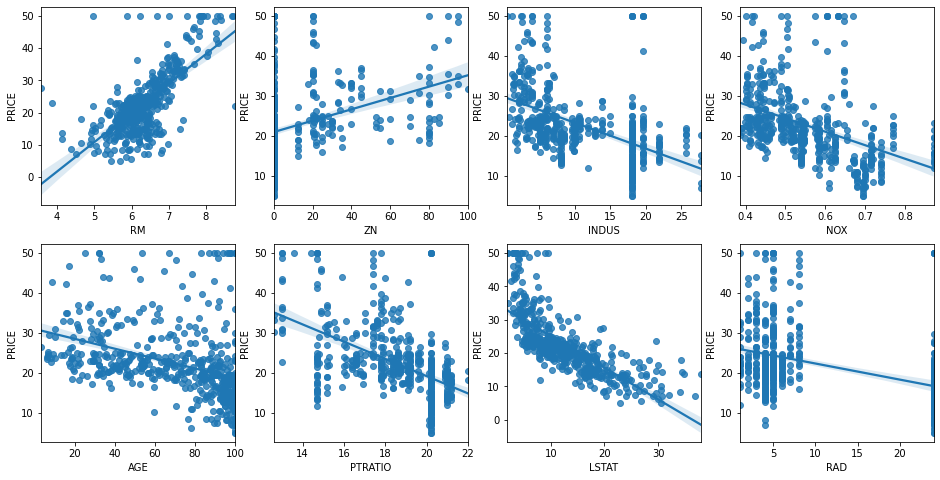

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2개의 행과 4개의 열을가진 그래프 그리기
fig, axs = plt.subplots(figsize = (16, 8), ncols=4, nrows=2)
features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']

for i, feature in enumerate(features):
  row = i//4
  col = i%4
  sns.regplot(x=feature, y='PRICE', data=df_data, ax=axs[row][col])

> 실행 결과 RM(방 수), LSTAT(하위 계층 비율) 두 가지가 가격에 영향을 미칠 것이라고 판단한다.

#3. 모델 만들기

##3.1 모델 만들기

In [7]:
df_labels = df_data['PRICE']
df_data.drop(['PRICE'], axis=1, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.3, random_state=62)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.7480226503450833

#4.  성능평가

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#예측값 얻기
pred = lr.predict(X_test)

#실제 값과 예측값에대한 거리
mse = mean_squared_error(y_test, pred)


rmse = np.sqrt(mse)

print(mse)
print(rmse)
print(r2_score(y_test, pred))

22.755428799001926
4.770265065905869
0.7480226503450833


> MSE(Mean Squared Error)는 실제값과 예측값의 차이를 제곱해 평균을 구한 것으로 분산과 같은 값을 갖게 된다. 두 값 간의 편차를 구하다 보면 음수가 발생함으로 제곱을 처리하게 된 것이고, 두 점 간의 거리를 대각성으로 하는 정사각형을 만들면 가로 제곱 더하기 세로제곱이 대각선의 제곱으로 표현됨으로 거리에 대한 표현이 사각형의 대각선의 길이와 같이 나타나기 때문에 Squared라는 이름을 사용하게 된 것이다.

> RMSE(Root Mean Squared Error)는 MSE의 제곱근으로 실제값과 예측값의 평균 편차가 된다.

> 이러한 값은 작을 수록 예측도가 높게 나타난다.

#5. 교차검증

In [17]:
from sklearn.linear_model  import LinearRegression

lr = LinearRegression()

In [18]:
from sklearn.model_selection import cross_val_score
import numpy as np

neg_mse_scores = cross_val_score(lr, df_data, df_labels, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)

print(neg_mse_scores)
print(rmse_scores)
print(np.mean(rmse_scores))

[-12.46030057 -26.04862111 -33.07413798 -80.76237112 -33.31360656]
[3.52991509 5.10378498 5.75101191 8.9867887  5.77179405]
5.828658946215802


> 예측 모델에서는 데이터(점수)가 크면 클수록 좋다는 판단을 하게 된다. 하지만 회귀 모델에서는 실 데이터와 예측 데이터의 거리를 구하여 성능평가를 하게 되는데, '거리가 멀다' 즉 수치로 큰 값이 나오게 되면 안좋은 성능으로 판단해야 하기 때문에, 데이터를 음수화 처리한 neg_mean_squared_error를 사용하는 것이다.

#6. 규제(Regularization)
> 학습 데이터에 대한 과적합을 방지하기 위해 penalty 부여
- L1: 가중치 합에 규제 강도를 곱한다.
- L2: 각 가중치 제곱의 합에 규제 강도를 곱한다.

> L2 규제가 L1규제에 비해 더 안정적이라 일반적으로 L2규제가 더 많이 사용된다.

#7. Ridge
> L2 규제 계수를 적용한 것으로 선형회귀에 가중치들의 제곱합에 대한 최소화를 추가한 알고리즘이다.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
import numpy as np

ridge = Ridge(alpha=10)

neg_mse_scores = cross_val_score(ridge, df_data, df_labels, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)

print(neg_mse_scores)
print(rmse_scores)
print(np.mean(rmse_scores))

[-11.4217962  -24.29446706 -28.14355069 -74.59916618 -28.51714218]
[3.3796148  4.92894178 5.30504955 8.63708088 5.3401444 ]
5.518166280868968


> alpha 파라미터를 조절하여 성능을 향상시킬 수 있다.

In [23]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
  ridge = Ridge(alpha= alpha)
  neg_mse_scores = cross_val_score(ridge, df_data, df_labels, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)

  print('alpha : ', alpha, ' - ', np.mean(rmse_scores))

alpha :  0  -  5.828658946215809
alpha :  0.1  -  5.7884866270324125
alpha :  1  -  5.652570965613546
alpha :  10  -  5.518166280868968
alpha :  100  -  5.329589628472143


> 최저값 : alphas = list(range(10, 1001))

#8. 라쏘
> 선형 회뒤에 L1 규제 계수를 적용한 것으로 가중치의 절대값의 합을 최소화 하는 계수를 추가한 알고리즘 이다. 덜 중요한 feature를 0으로 수렴하게 만들어 성능을 향상시킨다.


In [28]:
from sklearn.linear_model import Lasso

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
  lasso = Lasso(alpha= alpha)
  neg_mse_scores = cross_val_score(lasso, df_data, df_labels, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)

  print('alpha : ', alpha, ' - ', np.mean(rmse_scores))

alpha :  0  -  5.828658946215804
alpha :  0.1  -  5.615116035266935
alpha :  1  -  5.776020813823375
alpha :  10  -  6.585731788106536
alpha :  100  -  8.393274554563753


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4967.024500396032, tolerance: 3.919148542079209
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-

#9. 엘라스틱 넷
> Elastic Net은 L1과 L2를 함께 사용한다. L1의 비율은 l1_ratio옵션으로 조절한다.

In [29]:
from sklearn.linear_model import ElasticNet

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
  elastic_net = ElasticNet(alpha= alpha)
  neg_mse_scores = cross_val_score(elastic_net, df_data, df_labels, scoring='neg_mean_squared_error', cv=5)
  rmse_scores = np.sqrt(-1*neg_mse_scores)

  print('alpha : ', alpha, ' - ', np.mean(rmse_scores))

alpha :  0  -  5.828658946215804
alpha :  0.1  -  5.478389408572094
alpha :  1  -  5.521582384760585
alpha :  10  -  6.472030175947727
alpha :  100  -  8.311596560753728


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4967.024500396032, tolerance: 3.919148542079209
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-